In [2]:
import pandas as pd
import folium
import psycopg2
from dotenv import load_dotenv
import folium
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [3]:
load_dotenv('credentials.env')

# Print out the environment variables to confirm they're loaded
print("DB_HOST:", os.getenv("DB_HOST"))
print("DB_NAME:", os.getenv("DB_NAME"))
print("DB_USER:", os.getenv("DB_USER"))
print("DB_PASSWORD:", os.getenv("DB_PASSWORD"))
print("DB_PORT:", os.getenv("DB_PORT"))



DB_HOST: pinot.cs.ucsb.edu
DB_NAME: pinot
DB_USER: cs190nf24g10
DB_PASSWORD: YKUkr3GV
DB_PORT: 5432


In [10]:
try:
    conn = psycopg2.connect(
        host=os.getenv("DB_HOST"),
        database=os.getenv("DB_NAME"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        port=os.getenv("DB_PORT")
    )
    print("Connected successfully.")
    cur = conn.cursor()
    query = "SELECT time, signal, packet_loss FROM public.wifistats LIMIT 100;"
    cur.execute(query)
    data = cur.fetchall()

    wifi_df = pd.DataFrame(data, columns=['time', 'signal (dBm)', 'packet_loss'])
    wifi_df['time'] = pd.to_datetime(wifi_df['time'])
except Exception as e:
    print("Failed to connect to the database.")
    print("Error:", e)

Connected successfully.


In [11]:
try:
    if conn is not None:
        cur = conn.cursor()
        query = "SELECT label, time, signal, packet_loss FROM public.wifistats LIMIT 100;"
        cur.execute(query)
        data = cur.fetchall()
        for row in data:
            print(row)
        cur.close()
    else:
        print("Connection was not established.")
except Exception as e:
    print("Error executing the query.")
    print("Error:", e)

('raspi-e4:5f:01:ac:ed:5b', datetime.datetime(2024, 6, 24, 2, 39, 40, 280950), -66.0, 0.0)
('raspi-e4:5f:01:8d:ca:34', datetime.datetime(2024, 6, 24, 2, 39, 40, 281437), -65.0, 0.0)
('raspi-e4:5f:01:9c:20:81', datetime.datetime(2024, 6, 24, 2, 39, 40, 281833), -66.0, 0.0)
('raspi-e4:5f:01:8d:07:fe', datetime.datetime(2024, 6, 24, 2, 39, 40, 282211), -75.0, 0.0)
('raspi-e4:5f:01:8c:8a:41', datetime.datetime(2024, 6, 24, 2, 49, 55, 886456), -51.0, 0.0)
('raspi-e4:5f:01:56:d8:f3', datetime.datetime(2024, 6, 24, 2, 49, 55, 888764), -69.0, 0.0)
('raspi-e4:5f:01:9c:24:87', datetime.datetime(2024, 6, 24, 2, 49, 55, 889293), -53.0, 0.0)
('raspi-e4:5f:01:72:a4:93', datetime.datetime(2024, 6, 24, 2, 49, 55, 889729), -55.0, 0.0)
('raspi-e4:5f:01:6c:98:83', datetime.datetime(2024, 6, 24, 2, 49, 55, 890146), -46.0, 0.0)
('raspi-e4:5f:01:8b:bc:d9', datetime.datetime(2024, 6, 24, 2, 49, 55, 890686), -58.0, 0.0)
('raspi-e4:5f:01:a0:4a:dd', datetime.datetime(2024, 6, 24, 2, 49, 55, 891140), -40.0, 0.0)

       signal (dBm)  packet_loss
count     100.00000        100.0
mean      -57.26000          0.2
std         8.25921          2.0
min       -75.00000          0.0
25%       -65.00000          0.0
50%       -57.50000          0.0
75%       -51.75000          0.0
max       -38.00000         20.0


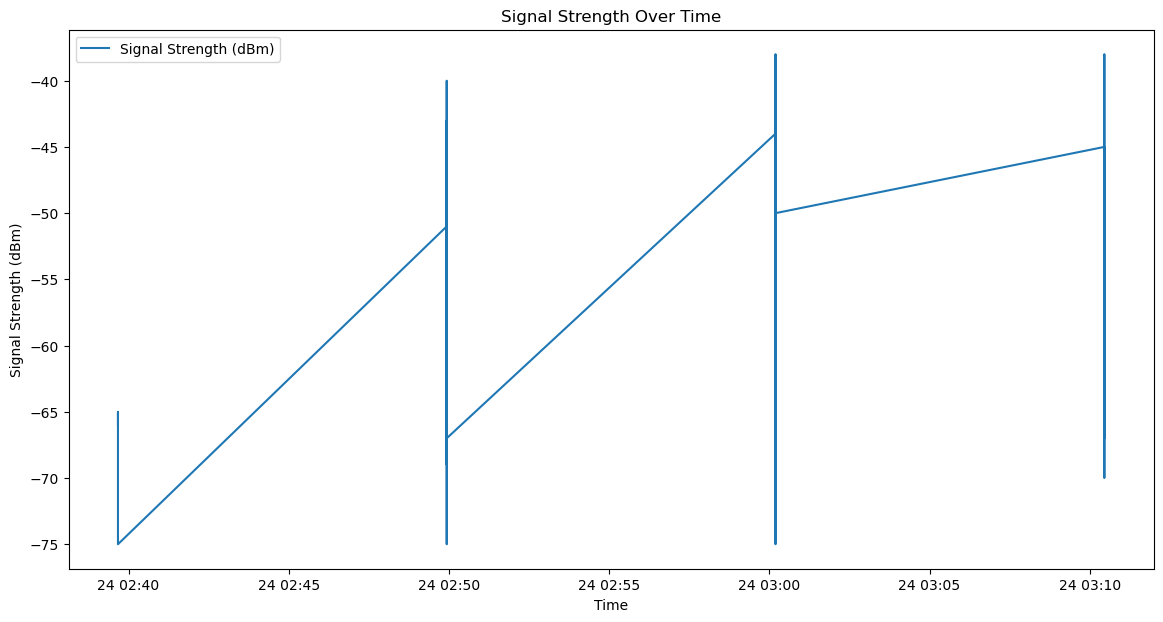

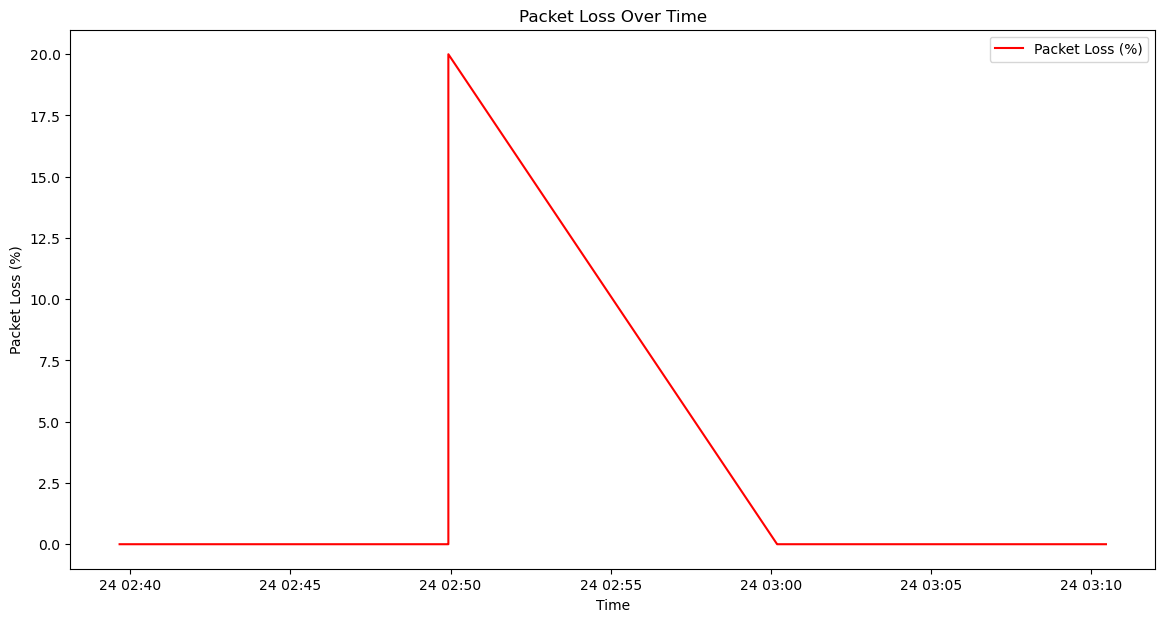

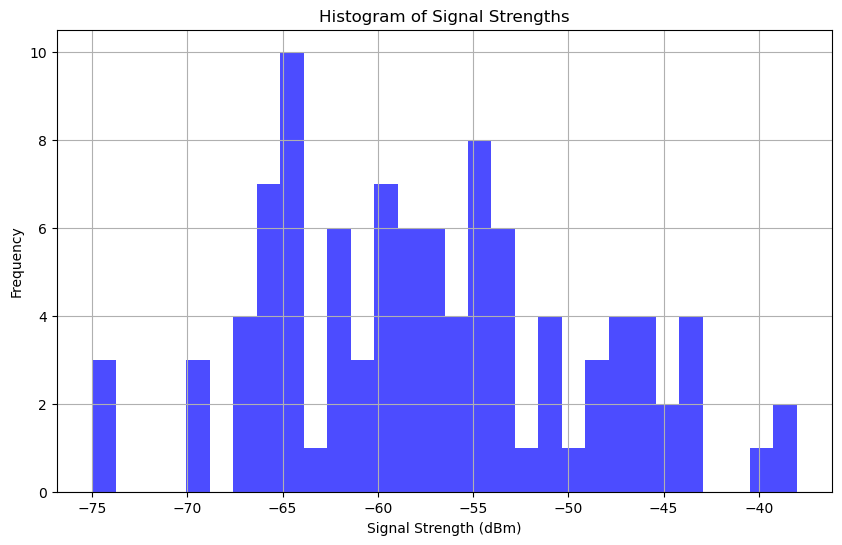

Correlation Matrix:
               signal (dBm)  packet_loss
signal (dBm)       1.00000     -0.11912
packet_loss       -0.11912      1.00000


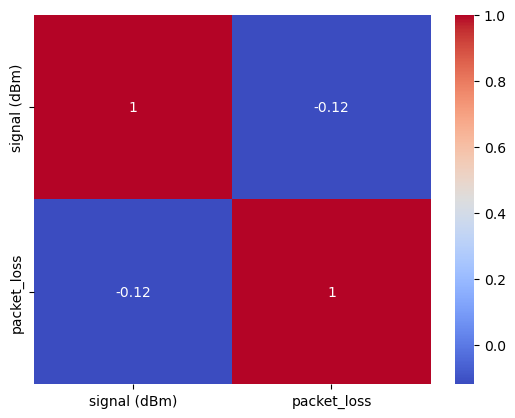

In [12]:
print(wifi_df.describe())

plt.figure(figsize=(14, 7))
plt.plot(wifi_df['time'], wifi_df['signal (dBm)'], label='Signal Strength (dBm)')
plt.title('Signal Strength Over Time')
plt.xlabel('Time')
plt.ylabel('Signal Strength (dBm)')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(wifi_df['time'], wifi_df['packet_loss'], label='Packet Loss (%)', color='red')
plt.title('Packet Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Loss (%)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(wifi_df['signal (dBm)'], bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Signal Strengths')
plt.xlabel('Signal Strength (dBm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

correlation = wifi_df[['signal (dBm)', 'packet_loss']].corr()
print("Correlation Matrix:\n", correlation)

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [13]:
cur = conn.cursor()
query = "SELECT time, signal, packet_loss FROM public.wifistats LIMIT 100;"
cur.execute(query)
data = cur.fetchall()
wifi_df = pd.DataFrame(data, columns=['time', 'signal (dBm)', 'packet_loss'])
wifi_df['time'] = pd.to_datetime(wifi_df['time'])
fig_signal = px.line(wifi_df, x='time', y='signal (dBm)', title='Signal Strength Over Time', labels={'signal (dBm)': 'Signal Strength (dBm)'})
fig_signal.update_xaxes(rangeslider_visible=True)
fig_signal.show()
fig_loss = px.line(wifi_df, x='time', y='packet_loss', title='Packet Loss Over Time', labels={'packet_loss': 'Packet Loss (%)'})
fig_loss.update_xaxes(rangeslider_visible=True)
fig_loss.show()